In [561]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier


In [562]:

df = pd.read_csv('framingham.csv')
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [563]:
print(len(df))
print(df['TenYearCHD'].value_counts())

4240
TenYearCHD
0    3596
1     644
Name: count, dtype: int64


In [564]:
df.dropna(axis = 0, inplace = True)
print(df['TenYearCHD'].value_counts())

TenYearCHD
0    3101
1     557
Name: count, dtype: int64


                     male       age  education  currentSmoker  cigsPerDay  \
male             1.000000 -0.024412   0.017729       0.206114    0.330322   
age             -0.024412  1.000000  -0.159499      -0.210771   -0.189295   
education        0.017729 -0.159499   1.000000       0.025251    0.013790   
currentSmoker    0.206114 -0.210771   0.025251       1.000000    0.773913   
cigsPerDay       0.330322 -0.189295   0.013790       0.773913    1.000000   
BPMeds          -0.052124  0.134732  -0.013739      -0.051923   -0.046504   
prevalentStroke -0.002312  0.050893  -0.030386      -0.038150   -0.036286   
prevalentHyp     0.001424  0.306239  -0.078828      -0.108078   -0.070460   
diabetes         0.013819  0.109092  -0.039627      -0.041849   -0.036961   
totChol         -0.070321  0.268252  -0.013522      -0.051034   -0.030400   
sysBP           -0.045358  0.388267  -0.124360      -0.134428   -0.094781   
diaBP            0.051872  0.208283  -0.058059      -0.115955   -0.056746   

<Axes: >

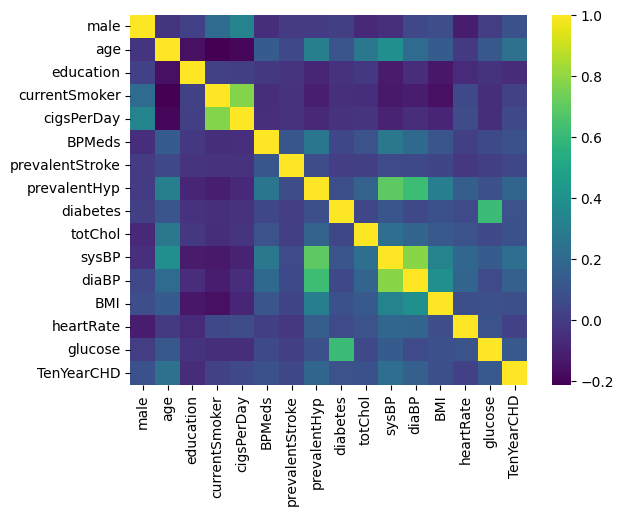

In [565]:
corr_matrix = df.corr()
print(corr_matrix)

sns.heatmap(corr_matrix, cmap = 'viridis')

In [566]:
features = df.drop('TenYearCHD', axis=1)  # Features
target = df['TenYearCHD'] 

feature_train, feature_test, output_train, output_test = train_test_split(features, target, test_size=0.25, random_state=1)

print ('Train set:', feature_train.shape,  output_train.shape)
print ('Test set:', feature_test.shape,  output_test.shape)


Train set: (2743, 15) (2743,)
Test set: (915, 15) (915,)


In [567]:
model = LogisticRegression(max_iter=5000)
model.fit(feature_train, output_train)

output_pred = model.predict(feature_test)


print("The accuracy of the Logistic regression model:", accuracy_score(output_test, output_pred))
print("The confusion matrix of the Logistic regression model is\n", confusion_matrix(output_test, output_pred))
print("The classification report of the Logistic regression model is\n", classification_report(output_test, output_pred))


The accuracy of the Logistic regression model: 0.8491803278688524
The confusion matrix of the Logistic regression model is
 [[766   9]
 [129  11]]
The classification report of the Logistic regression model is
               precision    recall  f1-score   support

           0       0.86      0.99      0.92       775
           1       0.55      0.08      0.14       140

    accuracy                           0.85       915
   macro avg       0.70      0.53      0.53       915
weighted avg       0.81      0.85      0.80       915



In [568]:
# features = preprocessing.StandardScaler().fit(features).transform(features)

# feature_train, feature_test, output_train, output_test = train_test_split(features, target, test_size=0.25, random_state=44)

# model = LogisticRegression(max_iter=1000)
# model.fit(feature_train, output_train)

# output_pred = model.predict(feature_test)


# print("The accuracy of the Logistic regression model:", accuracy_score(output_test, output_pred))
# print("The confusion matrix of the Logistic regression model is\n", confusion_matrix(output_test, output_pred))
# print("The classification report of the Logistic regression model is\n", classification_report(output_test, output_pred))

In [569]:
def stepwise_logistic_regression(X, y, cv=5, scoring='roc_auc', verbose=True):
    remaining_features = list(X.columns)
    selected_features = []
    best_score = 0
    while remaining_features:
        scores_with_candidates = []

        for candidate in remaining_features:
            current_features = selected_features + [candidate]
            model = LogisticRegression(max_iter=5000)
            score = cross_val_score(model, X[current_features], y, cv=cv, scoring=scoring).mean()
            scores_with_candidates.append((score, candidate))

        scores_with_candidates.sort(reverse=True)
        best_candidate_score, best_candidate = scores_with_candidates[0]

        if best_candidate_score > best_score:
            remaining_features.remove(best_candidate)
            selected_features.append(best_candidate)
            best_score = best_candidate_score
            if verbose:
                print(f"Add {best_candidate} with CV score: {best_candidate_score:.4f}")
        else:
            break

    return selected_features

In [570]:

selected = stepwise_logistic_regression(features, target)
print("Selected features:", selected)

Add age with CV score: 0.6853
Add sysBP with CV score: 0.7093
Add male with CV score: 0.7254
Add cigsPerDay with CV score: 0.7296
Add diabetes with CV score: 0.7322
Add prevalentHyp with CV score: 0.7332
Add prevalentStroke with CV score: 0.7335
Selected features: ['age', 'sysBP', 'male', 'cigsPerDay', 'diabetes', 'prevalentHyp', 'prevalentStroke']


In [571]:
step_selec_features = features[['age', 'sysBP', 'male', 'cigsPerDay', 'diabetes', 'prevalentHyp', 'prevalentStroke']]

feature_train, feature_test, output_train, output_test = train_test_split(step_selec_features, target, test_size=0.25, random_state=1)

model = LogisticRegression(max_iter=5000)
model.fit(feature_train, output_train)

output_pred = model.predict(feature_test)


print("The accuracy of the Logistic regression model:", accuracy_score(output_test, output_pred))
print("The confusion matrix of the Logistic regression model is\n", confusion_matrix(output_test, output_pred))
print("The classification report of the Logistic regression model is\n", classification_report(output_test, output_pred))



The accuracy of the Logistic regression model: 0.8546448087431694
The confusion matrix of the Logistic regression model is
 [[770   5]
 [128  12]]
The classification report of the Logistic regression model is
               precision    recall  f1-score   support

           0       0.86      0.99      0.92       775
           1       0.71      0.09      0.15       140

    accuracy                           0.85       915
   macro avg       0.78      0.54      0.54       915
weighted avg       0.83      0.85      0.80       915



In [572]:
model = LogisticRegression(penalty= 'l2', max_iter=5000)
model.fit(feature_train, output_train)

output_pred = model.predict(feature_test)


print("The accuracy of the Logistic regression model:", accuracy_score(output_test, output_pred))
print("The confusion matrix of the Logistic regression model is\n", confusion_matrix(output_test, output_pred))
print("The classification report of the Logistic regression model is\n", classification_report(output_test, output_pred))

The accuracy of the Logistic regression model: 0.8546448087431694
The confusion matrix of the Logistic regression model is
 [[770   5]
 [128  12]]
The classification report of the Logistic regression model is
               precision    recall  f1-score   support

           0       0.86      0.99      0.92       775
           1       0.71      0.09      0.15       140

    accuracy                           0.85       915
   macro avg       0.78      0.54      0.54       915
weighted avg       0.83      0.85      0.80       915



In [573]:
model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=5000)
model.fit(feature_train, output_train)

output_pred = model.predict(feature_test)


print("The accuracy of the Logistic regression model:", accuracy_score(output_test, output_pred))
print("The confusion matrix of the Logistic regression model is\n", confusion_matrix(output_test, output_pred))
print("The classification report of the Logistic regression model is\n", classification_report(output_test, output_pred))

The accuracy of the Logistic regression model: 0.8546448087431694
The confusion matrix of the Logistic regression model is
 [[770   5]
 [128  12]]
The classification report of the Logistic regression model is
               precision    recall  f1-score   support

           0       0.86      0.99      0.92       775
           1       0.71      0.09      0.15       140

    accuracy                           0.85       915
   macro avg       0.78      0.54      0.54       915
weighted avg       0.83      0.85      0.80       915



In [574]:
feature_train, feature_test, output_train, output_test = train_test_split(step_selec_features, target, test_size=0.25, random_state=10, stratify=target)



model = LogisticRegression(max_iter=5000)
model.fit(feature_train, output_train)

output_pred = model.predict(feature_test)


print("The accuracy of the Logistic regression model:", accuracy_score(output_test, output_pred))
print("The confusion matrix of the Logistic regression model is\n", confusion_matrix(output_test, output_pred))
print("The classification report of the Logistic regression model is\n", classification_report(output_test, output_pred))

The accuracy of the Logistic regression model: 0.853551912568306
The confusion matrix of the Logistic regression model is
 [[769   7]
 [127  12]]
The classification report of the Logistic regression model is
               precision    recall  f1-score   support

           0       0.86      0.99      0.92       776
           1       0.63      0.09      0.15       139

    accuracy                           0.85       915
   macro avg       0.74      0.54      0.54       915
weighted avg       0.82      0.85      0.80       915



In [575]:
smote = SMOTE(random_state=5)
X_scaled = StandardScaler().fit_transform(step_selec_features)
X_s, y_s = smote.fit_resample(X_scaled, target)


xs_train, xs_test, ys_train, ys_test = train_test_split(X_s, y_s, stratify=y_s, test_size=0.25, random_state=22)



model = LogisticRegression(max_iter=10000)
model.fit(xs_train, ys_train)

output_pred = model.predict(xs_test)


print("The accuracy of the Logistic regression model:", accuracy_score(ys_test, output_pred))
print("The confusion matrix of the Logistic regression model is\n", confusion_matrix(ys_test, output_pred))
print("The classification report of the Logistic regression model is\n", classification_report(ys_test, output_pred))

The accuracy of the Logistic regression model: 0.6640876853642811
The confusion matrix of the Logistic regression model is
 [[506 269]
 [252 524]]
The classification report of the Logistic regression model is
               precision    recall  f1-score   support

           0       0.67      0.65      0.66       775
           1       0.66      0.68      0.67       776

    accuracy                           0.66      1551
   macro avg       0.66      0.66      0.66      1551
weighted avg       0.66      0.66      0.66      1551



/Users/dipeshpaneru/Documents/UniveristyWork/Machine Learning/MachineLearningFramingham/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [576]:
rus = RandomUnderSampler(random_state=5)
X_scaled = StandardScaler().fit_transform(step_selec_features)

X_u, y_u = rus.fit_resample(X_scaled, target)


xu_train, xu_test, yu_train, yu_test = train_test_split(X_u, y_u, stratify=y_u, test_size=0.25, random_state=10)



model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=5000)
model.fit(xu_train, yu_train)

output_pred = model.predict(xu_test)


print("The accuracy of the Logistic regression model:", accuracy_score(yu_test, output_pred))
print("The confusion matrix of the Logistic regression model is\n", confusion_matrix(yu_test, output_pred))
print("The classification report of the Logistic regression model is\n", classification_report(yu_test, output_pred))

The accuracy of the Logistic regression model: 0.6810035842293907
The confusion matrix of the Logistic regression model is
 [[92 47]
 [42 98]]
The classification report of the Logistic regression model is
               precision    recall  f1-score   support

           0       0.69      0.66      0.67       139
           1       0.68      0.70      0.69       140

    accuracy                           0.68       279
   macro avg       0.68      0.68      0.68       279
weighted avg       0.68      0.68      0.68       279



/Users/dipeshpaneru/Documents/UniveristyWork/Machine Learning/MachineLearningFramingham/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dipeshpaneru/Documents/UniveristyWork/Machine Learning/MachineLearningFramingham/venv/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/dipeshpaneru/Documents/UniveristyWork/Machine Learning/MachineLearningFramingham/venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [577]:


model = Sequential([
    Dense(128, activation='relu', input_shape=(X_s.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history = model.fit(
    xs_train, ys_train,
    epochs=20,
    batch_size=32,
    verbose=1
)

y_pred_probs = model.predict(xs_test)
y_pred = (y_pred_probs > 0.5).astype("int")


print("The accuracy of the Logistic regression model:", accuracy_score(ys_test, y_pred))
print("The confusion matrix of the Logistic regression model is\n", confusion_matrix(ys_test, y_pred))
print("The classification report of the Logistic regression model is\n", classification_report(ys_test, y_pred))


Epoch 1/20


/Users/dipeshpaneru/Documents/UniveristyWork/Machine Learning/MachineLearningFramingham/venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.6105 - loss: 0.6554 - precision_45: 0.5983 - recall_45: 0.7247
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.6753 - loss: 0.6188 - precision_45: 0.6703 - recall_45: 0.7050
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.6697 - loss: 0.6071 - precision_45: 0.6725 - recall_45: 0.6798
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.6921 - loss: 0.5965 - precision_45: 0.6833 - recall_45: 0.7156
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.6857 - loss: 0.6031 - precision_45: 0.6726 - recall_45: 0.7131
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.6836 - loss: 0.6060 - precision_45: 0.6821 - recall_45: 0.6974
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.6958 - loss: 0.5950 - precision_45: 0.6902 - recall_45: 0.6943
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.6965 - loss: 0.5917 - prec

In [578]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_u.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history = model.fit(
    xu_train, yu_train,
    epochs=20,
    batch_size=32,
    verbose=1
)

y_pred_probs = model.predict(xu_test)
y_pred = (y_pred_probs > 0.5).astype("int")


print("The accuracy of the Logistic regression model:", accuracy_score(yu_test, y_pred))
print("The confusion matrix of the Logistic regression model is\n", confusion_matrix(yu_test, y_pred))
print("The classification report of the Logistic regression model is\n", classification_report(yu_test, y_pred))

Epoch 1/20


/Users/dipeshpaneru/Documents/UniveristyWork/Machine Learning/MachineLearningFramingham/venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5149 - loss: 0.7187 - precision_46: 0.5433 - recall_46: 0.3112   
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5916 - loss: 0.6655 - precision_46: 0.5779 - recall_46: 0.5429 
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6382 - loss: 0.6413 - precision_46: 0.6120 - recall_46: 0.6877 
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6321 - loss: 0.6396 - precision_46: 0.6197 - recall_46: 0.7240 
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6580 - loss: 0.6097 - precision_46: 0.6393 - recall_46: 0.6787 
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6527 - loss: 0.6218 - precision_46: 0.6320 - recall_46: 0.7188 
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6459 - loss: 0.6351 - precision_46: 0.6382 - recall_46: 0.7036 
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6213 - loss: 0.6468 - precision_46: 0.6033 - reca

In [579]:


model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(xs_train, ys_train)
y_pred = model.predict(xs_test)

print("The accuracy of the Logistic regression model:", accuracy_score(ys_test, y_pred))
print("The confusion matrix of the Logistic regression model is\n", confusion_matrix(ys_test, y_pred))
print("The classification report of the Logistic regression model is\n", classification_report(ys_test, y_pred))

The accuracy of the Logistic regression model: 0.8284977433913604
The confusion matrix of the Logistic regression model is
 [[682  93]
 [173 603]]
The classification report of the Logistic regression model is
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       775
           1       0.87      0.78      0.82       776

    accuracy                           0.83      1551
   macro avg       0.83      0.83      0.83      1551
weighted avg       0.83      0.83      0.83      1551



/Users/dipeshpaneru/Documents/UniveristyWork/Machine Learning/MachineLearningFramingham/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [580]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(xu_train, yu_train)
y_pred = model.predict(xu_test)

print("The accuracy of the Logistic regression model:", accuracy_score(yu_test, y_pred))
print("The confusion matrix of the Logistic regression model is\n", confusion_matrix(yu_test, y_pred))
print("The classification report of the Logistic regression model is\n", classification_report(yu_test, y_pred))

/Users/dipeshpaneru/Documents/UniveristyWork/Machine Learning/MachineLearningFramingham/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


The accuracy of the Logistic regression model: 0.6200716845878136
The confusion matrix of the Logistic regression model is
 [[82 57]
 [49 91]]
The classification report of the Logistic regression model is
               precision    recall  f1-score   support

           0       0.63      0.59      0.61       139
           1       0.61      0.65      0.63       140

    accuracy                           0.62       279
   macro avg       0.62      0.62      0.62       279
weighted avg       0.62      0.62      0.62       279



In [581]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(feature_train, output_train)

output_pred = model.predict(feature_test)


print("The accuracy of the Logistic regression model:", accuracy_score(output_test, output_pred))
print("The confusion matrix of the Logistic regression model is\n", confusion_matrix(output_test, output_pred))
print("The classification report of the Logistic regression model is\n", classification_report(output_test, output_pred))

/Users/dipeshpaneru/Documents/UniveristyWork/Machine Learning/MachineLearningFramingham/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


The accuracy of the Logistic regression model: 0.819672131147541
The confusion matrix of the Logistic regression model is
 [[732  44]
 [121  18]]
The classification report of the Logistic regression model is
               precision    recall  f1-score   support

           0       0.86      0.94      0.90       776
           1       0.29      0.13      0.18       139

    accuracy                           0.82       915
   macro avg       0.57      0.54      0.54       915
weighted avg       0.77      0.82      0.79       915

